# Pokemon Classifier - CNN from Scratch (Gen 1)

Classification de 151 Pokémon avec un CNN custom.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models

print(f"TensorFlow: {tf.__version__}")

TensorFlow: 2.16.2


## Chargement des données

In [42]:
data_path = Path('./PokemonData')
image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}

pokemon_dirs = sorted([d for d in data_path.iterdir() if d.is_dir()])
image_paths, labels = [], []

for pokemon_dir in pokemon_dirs:
    for img in pokemon_dir.iterdir():
        if img.suffix.lower() in image_extensions:
            image_paths.append(str(img))
            labels.append(pokemon_dir.name)

image_paths = np.array(image_paths)
labels = np.array(labels)

print(f"Images: {len(image_paths)} | Classes: {len(np.unique(labels))}")

Images: 32471 | Classes: 151


## Analyse du dataset

In [43]:
image_counts = {d.name: len([f for f in d.iterdir() if f.suffix.lower() in image_extensions]) 
                for d in pokemon_dirs}
counts = pd.Series(image_counts)

print(f"Classes: {len(pokemon_dirs)} | Total: {counts.sum()} images")
print(f"Min: {counts.min()} | Max: {counts.max()} | Moyenne: {counts.mean():.0f}")
print(f"\nMoins d'images: {counts.nsmallest(3).to_dict()}")
print(f"Plus d'images: {counts.nlargest(3).to_dict()}")

Classes: 151 | Total: 32471 images
Min: 117 | Max: 486 | Moyenne: 215

Moins d'images: {'Nidoran♀': 117, 'Persian': 125, 'Onix': 128}
Plus d'images: {'Pikachu': 486, 'Salamèche': 451, 'Mewtwo': 439}


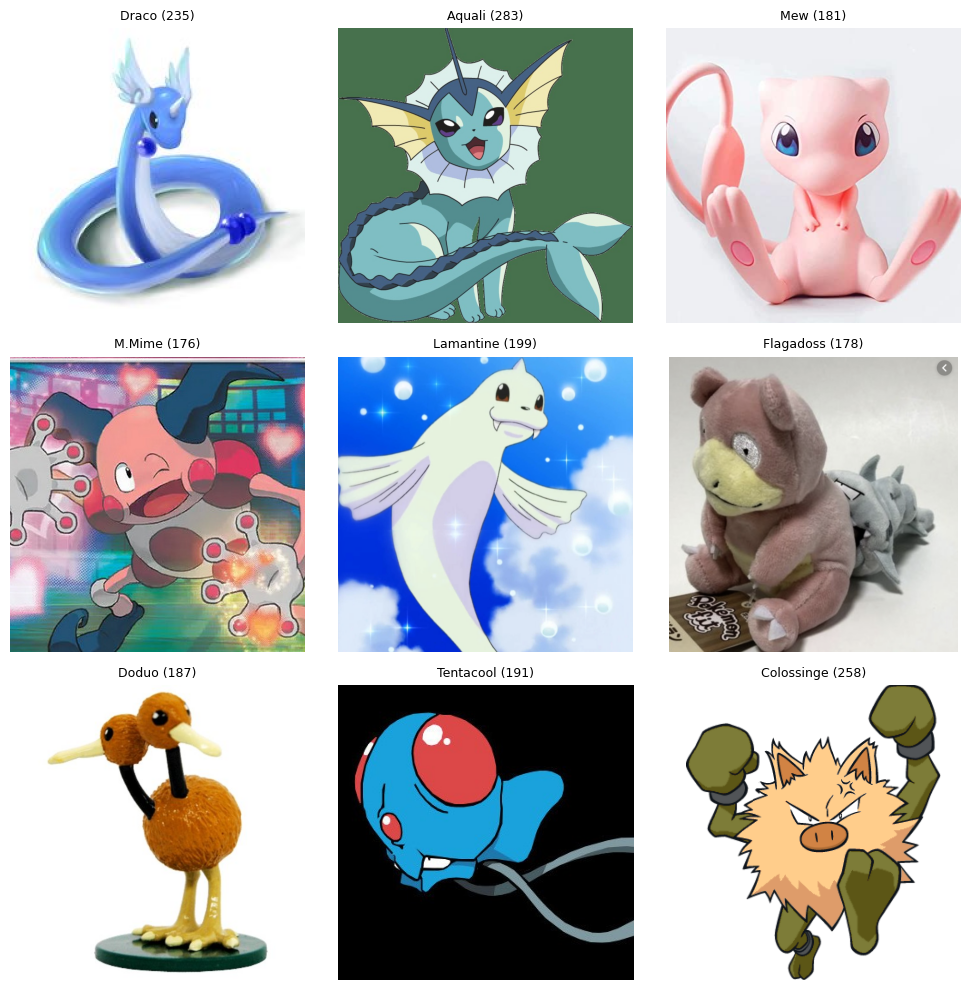

In [44]:
import random
from PIL import Image

random.seed(42)
sample_dirs = random.sample(pokemon_dirs, 9)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for idx, pokemon_dir in enumerate(sample_dirs):
    images = [f for f in pokemon_dir.iterdir() if f.suffix.lower() in image_extensions]
    if images:
        img = Image.open(images[0])
        axes.flat[idx].imshow(img)
        axes.flat[idx].set_title(f"{pokemon_dir.name} ({len(images)})", fontsize=9)
        axes.flat[idx].axis('off')
plt.tight_layout()
plt.show()

## Split Train/Val/Test (80/10/10)

In [45]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

print(f"Train: {len(train_paths)} | Val: {len(val_paths)} | Test: {len(test_paths)}")

Train: 25976 | Val: 3247 | Test: 3248


## Architecture CNN

In [46]:
num_classes = len(np.unique(labels))
image_shape = (256, 256, 3)

model = models.Sequential([
    layers.Input(image_shape),
    
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Classifier
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()
print(f"\nParamètres: {model.count_params():,}")

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 361,655 (1.38 MB)

 Trainable params: 360,247 (1.37 MB)

 Non-trainable params: 1,408 (5.50 KB)


Paramètres: 361,655


## Préparation des données et augmentation

In [47]:
unique_labels = sorted(np.unique(train_labels))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

train_labels_onehot = tf.keras.utils.to_categorical([label_to_idx[l] for l in train_labels], num_classes)
val_labels_onehot = tf.keras.utils.to_categorical([label_to_idx[l] for l in val_labels], num_classes)
test_labels_onehot = tf.keras.utils.to_categorical([label_to_idx[l] for l in test_labels], num_classes)

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (256, 256))
    return img, label

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.15),
    layers.RandomBrightness(0.15),
])

def augment_and_normalize(img, label):
    img = data_augmentation(img, training=True)
    return img / 255.0, label

def normalize_only(img, label):
    return img / 255.0, label

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

train_dataset = (tf.data.Dataset.from_tensor_slices((train_paths, train_labels_onehot))
    .map(load_image, num_parallel_calls=AUTOTUNE)
    .map(augment_and_normalize, num_parallel_calls=AUTOTUNE)
    .shuffle(1000).batch(batch_size).prefetch(AUTOTUNE))

val_dataset = (tf.data.Dataset.from_tensor_slices((val_paths, val_labels_onehot))
    .map(load_image, num_parallel_calls=AUTOTUNE)
    .map(normalize_only, num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE))

test_dataset = (tf.data.Dataset.from_tensor_slices((test_paths, test_labels_onehot))
    .map(load_image, num_parallel_calls=AUTOTUNE)
    .map(normalize_only, num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE))

print("Datasets prêts")

Datasets prêts


## Entraînement

In [48]:
def warmup_cosine_decay(epoch, total_epochs=50, warmup_epochs=5, initial_lr=0.001, min_lr=1e-6):
    if epoch < warmup_epochs:
        return initial_lr * (epoch / warmup_epochs)
    progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
    return min_lr + (initial_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * progress))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.LearningRateScheduler(warmup_cosine_decay, verbose=0),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 4:26 518ms/step - accuracy: 0.0088 - loss: 6.2179

2025-12-04 21:31:08.945556: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:55 534ms/step - accuracy: 0.0086 - loss: 6.2201

2025-12-04 21:33:53.310873: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 20s 523ms/step - accuracy: 0.0084 - loss: 6.2189

2025-12-04 21:35:19.016243: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 435s 530ms/step - accuracy: 0.0080 - loss: 6.2159 - val_accuracy: 0.0068 - val_loss: 6.8019 - learning_rate: 0.0000e+00
Epoch 2/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 4:15 496ms/step - accuracy: 0.0165 - loss: 5.6639

2025-12-04 21:38:14.209414: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:40 465ms/step - accuracy: 0.0222 - loss: 5.4611

2025-12-04 21:40:24.172230: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - accuracy: 0.0251 - loss: 5.3760

2025-12-04 21:41:38.460118: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 377s 463ms/step - accuracy: 0.0382 - loss: 5.0186 - val_accuracy: 0.0751 - val_loss: 4.3968 - learning_rate: 2.0000e-04
Epoch 3/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:50 447ms/step - accuracy: 0.0634 - loss: 4.5893

2025-12-04 21:44:16.705977: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:35 441ms/step - accuracy: 0.0653 - loss: 4.5415

2025-12-04 21:46:26.811339: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 17s 446ms/step - accuracy: 0.0670 - loss: 4.5140

2025-12-04 21:47:48.231836: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 370s 454ms/step - accuracy: 0.0754 - loss: 4.3900 - val_accuracy: 0.1232 - val_loss: 3.9098 - learning_rate: 4.0000e-04
Epoch 4/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:50 448ms/step - accuracy: 0.0949 - loss: 4.1885

2025-12-04 21:50:27.719418: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:27 407ms/step - accuracy: 0.0966 - loss: 4.1583

2025-12-04 21:52:17.072654: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 15s 390ms/step - accuracy: 0.0982 - loss: 4.1388

2025-12-04 21:53:16.047519: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 321s 393ms/step - accuracy: 0.1060 - loss: 4.0511 - val_accuracy: 0.1226 - val_loss: 4.6404 - learning_rate: 6.0000e-04
Epoch 5/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 2:45 322ms/step - accuracy: 0.1200 - loss: 3.9125

2025-12-04 21:55:11.102778: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:22 382ms/step - accuracy: 0.1239 - loss: 3.8800

2025-12-04 21:57:22.839350: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 15s 392ms/step - accuracy: 0.1263 - loss: 3.8619

2025-12-04 21:58:37.895323: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 331s 406ms/step - accuracy: 0.1386 - loss: 3.7815 - val_accuracy: 0.1802 - val_loss: 3.5726 - learning_rate: 8.0000e-04
Epoch 6/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:59 464ms/step - accuracy: 0.1687 - loss: 3.6313

2025-12-04 22:01:24.819902: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:38 454ms/step - accuracy: 0.1710 - loss: 3.6122

2025-12-04 22:03:37.820609: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 17s 446ms/step - accuracy: 0.1727 - loss: 3.5973

2025-12-04 22:04:51.207663: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 370s 453ms/step - accuracy: 0.1813 - loss: 3.5292 - val_accuracy: 0.1253 - val_loss: 4.6198 - learning_rate: 0.0010
Epoch 7/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:44 436ms/step - accuracy: 0.2141 - loss: 3.3468

2025-12-04 22:07:26.078703: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:36 446ms/step - accuracy: 0.2169 - loss: 3.3241

2025-12-04 22:09:42.204158: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 17s 441ms/step - accuracy: 0.2187 - loss: 3.3120

2025-12-04 22:10:57.077393: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 366s 449ms/step - accuracy: 0.2281 - loss: 3.2584 - val_accuracy: 0.2261 - val_loss: 3.4605 - learning_rate: 9.0457e-04
Epoch 8/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:39 426ms/step - accuracy: 0.2642 - loss: 3.0802

2025-12-04 22:13:29.395461: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:31 423ms/step - accuracy: 0.2675 - loss: 3.0640

2025-12-04 22:15:35.120793: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 423ms/step - accuracy: 0.2699 - loss: 3.0529

2025-12-04 22:16:49.670931: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 353s 432ms/step - accuracy: 0.2801 - loss: 3.0054 - val_accuracy: 0.1962 - val_loss: 4.1363 - learning_rate: 6.5475e-04
Epoch 9/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:41 431ms/step - accuracy: 0.3128 - loss: 2.8389

2025-12-04 22:19:23.252961: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:33 433ms/step - accuracy: 0.3176 - loss: 2.8232

2025-12-04 22:21:33.265900: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 17s 432ms/step - accuracy: 0.3200 - loss: 2.8152

2025-12-04 22:22:48.599837: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 359s 439ms/step - accuracy: 0.3301 - loss: 2.7761 - val_accuracy: 0.3446 - val_loss: 2.7219 - learning_rate: 3.4603e-04
Epoch 10/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:31 410ms/step - accuracy: 0.3644 - loss: 2.6151

2025-12-04 22:25:15.548459: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:30 417ms/step - accuracy: 0.3656 - loss: 2.6138

2025-12-04 22:27:22.315836: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 417ms/step - accuracy: 0.3664 - loss: 2.6103

2025-12-04 22:28:35.579946: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 347s 425ms/step - accuracy: 0.3705 - loss: 2.5926 - val_accuracy: 0.3936 - val_loss: 2.5526 - learning_rate: 9.6345e-05
Epoch 11/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:36 420ms/step - accuracy: 0.3929 - loss: 2.5332

2025-12-04 22:31:05.676986: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:30 419ms/step - accuracy: 0.3888 - loss: 2.5449

2025-12-04 22:33:10.927003: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 420ms/step - accuracy: 0.3878 - loss: 2.5464

2025-12-04 22:34:25.033751: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 349s 428ms/step - accuracy: 0.3877 - loss: 2.5432 - val_accuracy: 0.4078 - val_loss: 2.5044 - learning_rate: 1.0000e-06
Epoch 12/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:30 408ms/step - accuracy: 0.3784 - loss: 2.5577

2025-12-04 22:36:51.160072: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:27 407ms/step - accuracy: 0.3810 - loss: 2.5502

2025-12-04 22:38:52.481392: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 409ms/step - accuracy: 0.3813 - loss: 2.5489

2025-12-04 22:40:05.970285: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 341s 418ms/step - accuracy: 0.3828 - loss: 2.5429 - val_accuracy: 0.4115 - val_loss: 2.4688 - learning_rate: 9.6396e-05
Epoch 13/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:36 420ms/step - accuracy: 0.3789 - loss: 2.5409

2025-12-04 22:42:35.849619: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:29 416ms/step - accuracy: 0.3744 - loss: 2.5613

2025-12-04 22:44:39.109092: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 418ms/step - accuracy: 0.3736 - loss: 2.5662

2025-12-04 22:45:53.849142: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 348s 426ms/step - accuracy: 0.3711 - loss: 2.5797 - val_accuracy: 0.4044 - val_loss: 2.5198 - learning_rate: 3.4619e-04
Epoch 14/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:32 413ms/step - accuracy: 0.3644 - loss: 2.6008

2025-12-04 22:48:21.598524: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:28 409ms/step - accuracy: 0.3619 - loss: 2.6220

2025-12-04 22:50:22.836591: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 410ms/step - accuracy: 0.3625 - loss: 2.6242

2025-12-04 22:51:35.311664: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 341s 418ms/step - accuracy: 0.3667 - loss: 2.6256 - val_accuracy: 0.3286 - val_loss: 2.9226 - learning_rate: 6.5502e-04
Epoch 15/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:26 401ms/step - accuracy: 0.3675 - loss: 2.6034

2025-12-04 22:53:59.151824: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:28 409ms/step - accuracy: 0.3670 - loss: 2.6070

2025-12-04 22:56:03.642335: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 410ms/step - accuracy: 0.3673 - loss: 2.6062

2025-12-04 22:57:16.785326: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 342s 419ms/step - accuracy: 0.3716 - loss: 2.5968 - val_accuracy: 0.3274 - val_loss: 3.0997 - learning_rate: 9.0482e-04
Epoch 16/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:38 425ms/step - accuracy: 0.4027 - loss: 2.5029

2025-12-04 22:59:48.610975: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:30 419ms/step - accuracy: 0.4036 - loss: 2.4965

2025-12-04 23:01:51.784426: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 415ms/step - accuracy: 0.4040 - loss: 2.4922

2025-12-04 23:03:03.023283: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 345s 423ms/step - accuracy: 0.4052 - loss: 2.4772 - val_accuracy: 0.3970 - val_loss: 2.5337 - learning_rate: 1.0000e-03
Epoch 17/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:31 411ms/step - accuracy: 0.4310 - loss: 2.3714

2025-12-04 23:05:29.139435: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:27 406ms/step - accuracy: 0.4308 - loss: 2.3683

2025-12-04 23:07:29.264893: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 408ms/step - accuracy: 0.4315 - loss: 2.3649

2025-12-04 23:08:42.509304: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 340s 417ms/step - accuracy: 0.4340 - loss: 2.3519 - val_accuracy: 0.4512 - val_loss: 2.3123 - learning_rate: 9.0420e-04
Epoch 18/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:31 411ms/step - accuracy: 0.4704 - loss: 2.2096

2025-12-04 23:11:09.652724: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:27 407ms/step - accuracy: 0.4708 - loss: 2.2015

2025-12-04 23:13:09.872474: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 405ms/step - accuracy: 0.4714 - loss: 2.1968

2025-12-04 23:14:19.896078: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 337s 413ms/step - accuracy: 0.4742 - loss: 2.1783 - val_accuracy: 0.4084 - val_loss: 2.4422 - learning_rate: 6.5421e-04
Epoch 19/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:41 430ms/step - accuracy: 0.5083 - loss: 2.0206

2025-12-04 23:16:52.422899: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:30 418ms/step - accuracy: 0.5109 - loss: 2.0128

2025-12-04 23:18:54.237402: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 418ms/step - accuracy: 0.5119 - loss: 2.0073

2025-12-04 23:20:07.386876: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 348s 427ms/step - accuracy: 0.5166 - loss: 1.9853 - val_accuracy: 0.4838 - val_loss: 2.1838 - learning_rate: 3.4564e-04
Epoch 20/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:38 424ms/step - accuracy: 0.5307 - loss: 1.9228

2025-12-04 23:22:39.140968: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:31 422ms/step - accuracy: 0.5357 - loss: 1.9061

2025-12-04 23:24:44.683933: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 417ms/step - accuracy: 0.5375 - loss: 1.8989

2025-12-04 23:25:54.959939: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 347s 425ms/step - accuracy: 0.5452 - loss: 1.8693 - val_accuracy: 0.5627 - val_loss: 1.8344 - learning_rate: 9.6218e-05
Epoch 21/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:34 416ms/step - accuracy: 0.5517 - loss: 1.8234

2025-12-04 23:28:23.536634: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:28 412ms/step - accuracy: 0.5495 - loss: 1.8344

2025-12-04 23:30:25.526039: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 411ms/step - accuracy: 0.5498 - loss: 1.8362

2025-12-04 23:31:37.543561: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 342s 419ms/step - accuracy: 0.5535 - loss: 1.8358 - val_accuracy: 0.5704 - val_loss: 1.8132 - learning_rate: 1.0000e-06
Epoch 22/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:28 404ms/step - accuracy: 0.5536 - loss: 1.8324

2025-12-04 23:34:02.195817: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:29 413ms/step - accuracy: 0.5508 - loss: 1.8450

2025-12-04 23:36:08.523065: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 410ms/step - accuracy: 0.5504 - loss: 1.8463

2025-12-04 23:37:18.866609: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 341s 418ms/step - accuracy: 0.5493 - loss: 1.8477 - val_accuracy: 0.5738 - val_loss: 1.7957 - learning_rate: 9.6397e-05
Epoch 23/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:29 407ms/step - accuracy: 0.5491 - loss: 1.8588

2025-12-04 23:39:44.056725: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:29 413ms/step - accuracy: 0.5452 - loss: 1.8751

2025-12-04 23:41:49.146985: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 415ms/step - accuracy: 0.5441 - loss: 1.8803

2025-12-04 23:43:03.301922: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 345s 422ms/step - accuracy: 0.5396 - loss: 1.9008 - val_accuracy: 0.5383 - val_loss: 1.9674 - learning_rate: 3.4624e-04
Epoch 24/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:29 406ms/step - accuracy: 0.5302 - loss: 1.9400

2025-12-04 23:45:28.456138: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:29 413ms/step - accuracy: 0.5288 - loss: 1.9501

2025-12-04 23:47:34.271367: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 412ms/step - accuracy: 0.5280 - loss: 1.9544

2025-12-04 23:48:46.218405: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 343s 421ms/step - accuracy: 0.5243 - loss: 1.9753 - val_accuracy: 0.4897 - val_loss: 2.1798 - learning_rate: 6.5523e-04
Epoch 25/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:36 420ms/step - accuracy: 0.5391 - loss: 1.9526

2025-12-04 23:51:15.772934: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:30 418ms/step - accuracy: 0.5303 - loss: 1.9693

2025-12-04 23:53:20.391076: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 420ms/step - accuracy: 0.5274 - loss: 1.9760

2025-12-04 23:54:35.061628: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 349s 428ms/step - accuracy: 0.5180 - loss: 2.0020 - val_accuracy: 0.5251 - val_loss: 2.0276 - learning_rate: 9.0506e-04
Epoch 26/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:36 420ms/step - accuracy: 0.5189 - loss: 1.9828

2025-12-04 23:57:04.745553: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:29 413ms/step - accuracy: 0.5160 - loss: 1.9870

2025-12-04 23:59:06.059639: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 411ms/step - accuracy: 0.5156 - loss: 1.9878

2025-12-05 00:00:17.677354: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 342s 419ms/step - accuracy: 0.5140 - loss: 1.9968 - val_accuracy: 0.5276 - val_loss: 2.0178 - learning_rate: 1.0000e-03
Epoch 27/50
297/812 ━━━━━━━━━━━━━━━━━━━━ 3:36 420ms/step - accuracy: 0.5488 - loss: 1.8880

2025-12-05 00:02:47.189762: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 1:30 419ms/step - accuracy: 0.5472 - loss: 1.8810

2025-12-05 00:04:52.326349: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 16s 416ms/step - accuracy: 0.5463 - loss: 1.8811

2025-12-05 00:06:03.101997: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 346s 424ms/step - accuracy: 0.5414 - loss: 1.8877 - val_accuracy: 0.5544 - val_loss: 2.0257 - learning_rate: 9.0383e-04


## Courbes d'entraînement

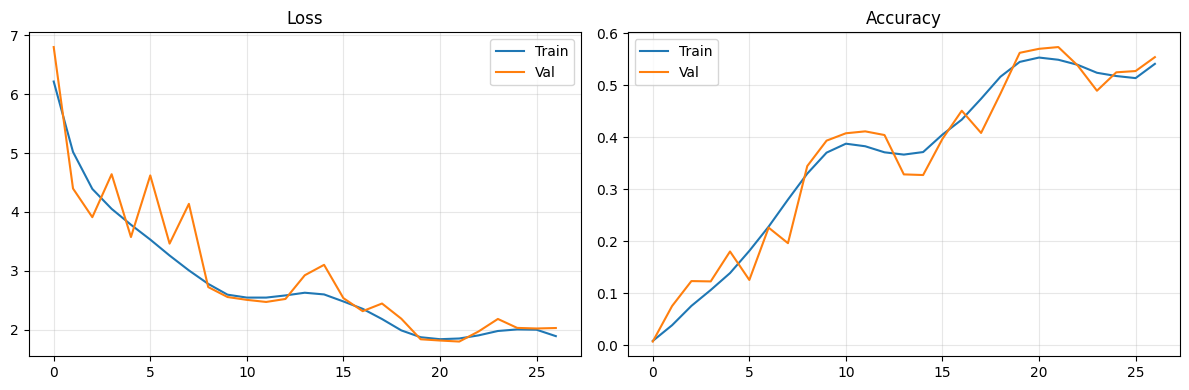

Meilleure val accuracy: 0.5738


In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Val')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['accuracy'], label='Train')
ax2.plot(history.history['val_accuracy'], label='Val')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Meilleure val accuracy: {max(history.history['val_accuracy']):.4f}")

## Sauvegarde

In [50]:
model.save('pokemon_classifier.keras')
print("Modèle sauvegardé: pokemon_classifier.keras")

Modèle sauvegardé: pokemon_classifier.keras


## Évaluation sur le Test Set

In [51]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.6056 - loss: 1.6811

Test Accuracy: 0.6056 (60.56%)
Test Loss: 1.6811


## Matrice de confusion - Top 20 classes

102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step


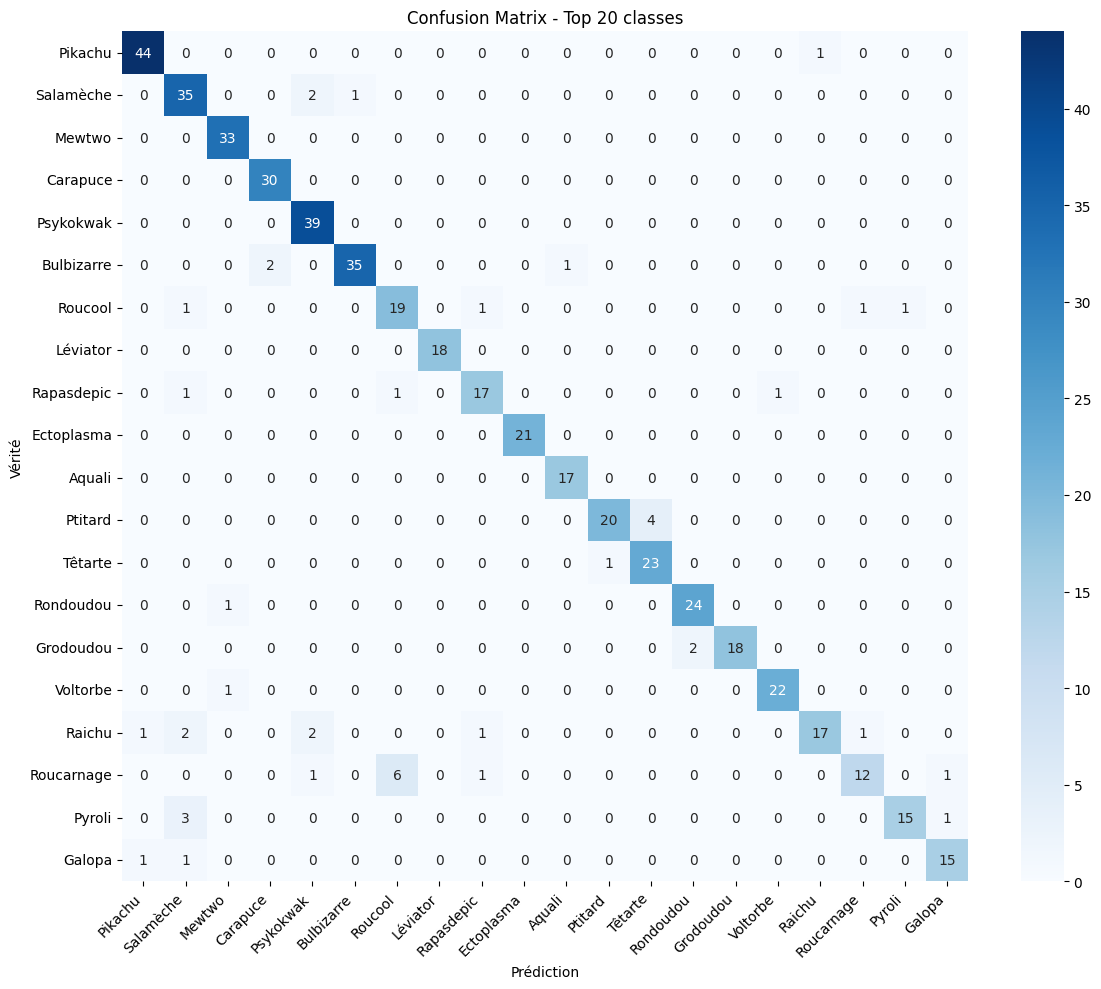

In [52]:
y_pred_proba = model.predict(test_dataset)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(test_labels_onehot, axis=1)

top_20_classes = pd.Series(y_true).value_counts().head(20).index.tolist()
top_20_names = [list(label_to_idx.keys())[i] for i in top_20_classes]

mask = np.isin(y_true, top_20_classes)
cm = confusion_matrix(y_true[mask], y_pred[mask], labels=top_20_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=top_20_names, yticklabels=top_20_names)
plt.title('Confusion Matrix - Top 20 classes')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Matrice de confusion - Worst 20 classes

Classes avec le plus d'erreurs de classification.

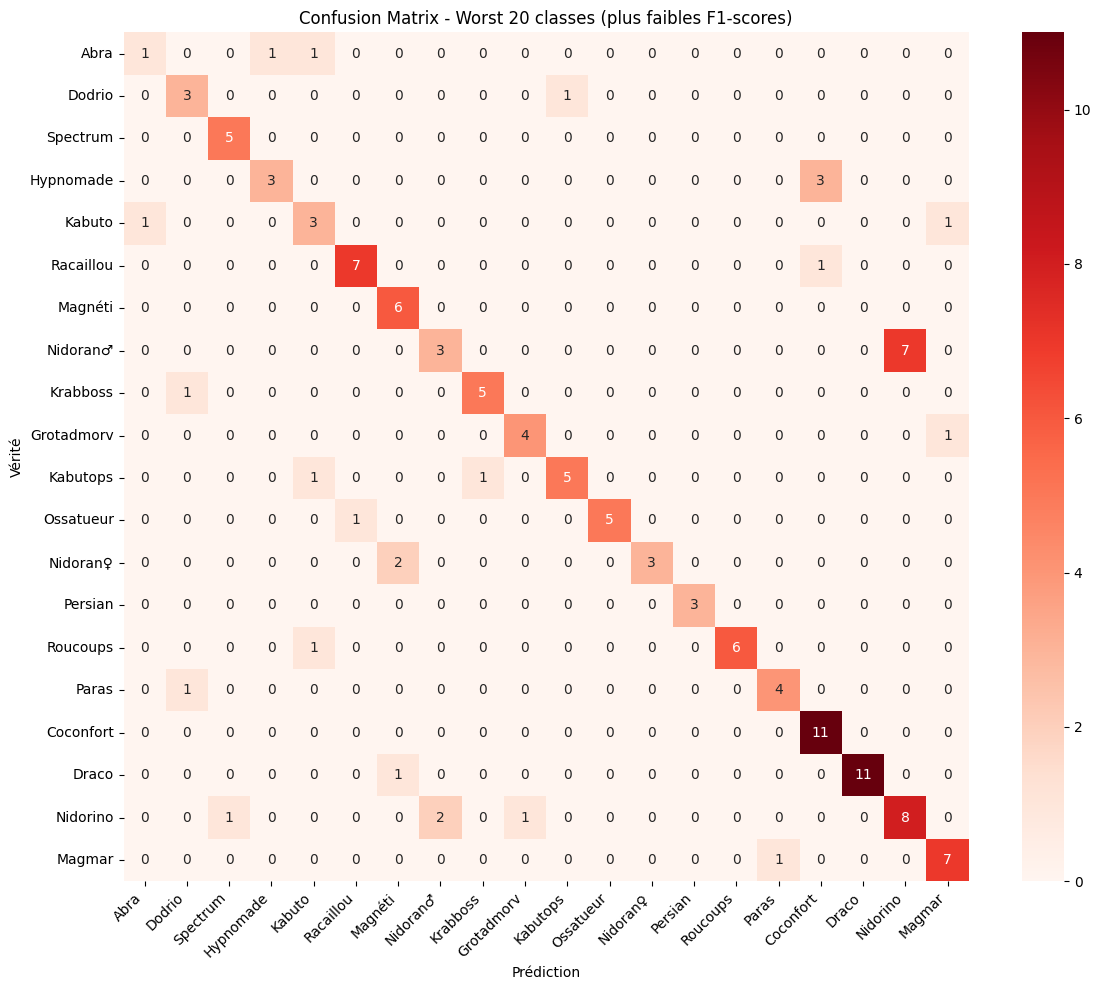


Classes avec les plus faibles performances:
  Abra: F1=0.125
  Dodrio: F1=0.250
  Spectrum: F1=0.263
  Hypnomade: F1=0.273
  Kabuto: F1=0.300
  Racaillou: F1=0.304
  Magnéti: F1=0.308
  Nidoran♂: F1=0.316
  Krabboss: F1=0.323
  Grotadmorv: F1=0.333


In [53]:
report = classification_report(y_true, y_pred, target_names=list(label_to_idx.keys()), 
                               output_dict=True, zero_division=0)

class_f1 = {name: report[name]['f1-score'] for name in label_to_idx.keys()}
worst_20_names = sorted(class_f1, key=class_f1.get)[:20]
worst_20_classes = [label_to_idx[name] for name in worst_20_names]

mask_worst = np.isin(y_true, worst_20_classes)
cm_worst = confusion_matrix(y_true[mask_worst], y_pred[mask_worst], labels=worst_20_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_worst, annot=True, fmt='d', cmap='Reds', 
            xticklabels=worst_20_names, yticklabels=worst_20_names)
plt.title('Confusion Matrix - Worst 20 classes (plus faibles F1-scores)')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nClasses avec les plus faibles performances:")
for name in worst_20_names[:10]:
    print(f"  {name}: F1={class_f1[name]:.3f}")

## Métriques globales

In [54]:
print(f"Accuracy:  {report['accuracy']:.4f}")
print(f"Precision: {report['macro avg']['precision']:.4f}")
print(f"Recall:    {report['macro avg']['recall']:.4f}")
print(f"F1-Score:  {report['macro avg']['f1-score']:.4f}")

Accuracy:  0.6056
Precision: 0.6244
Recall:    0.5852
F1-Score:  0.5882


## Visualisation des prédictions

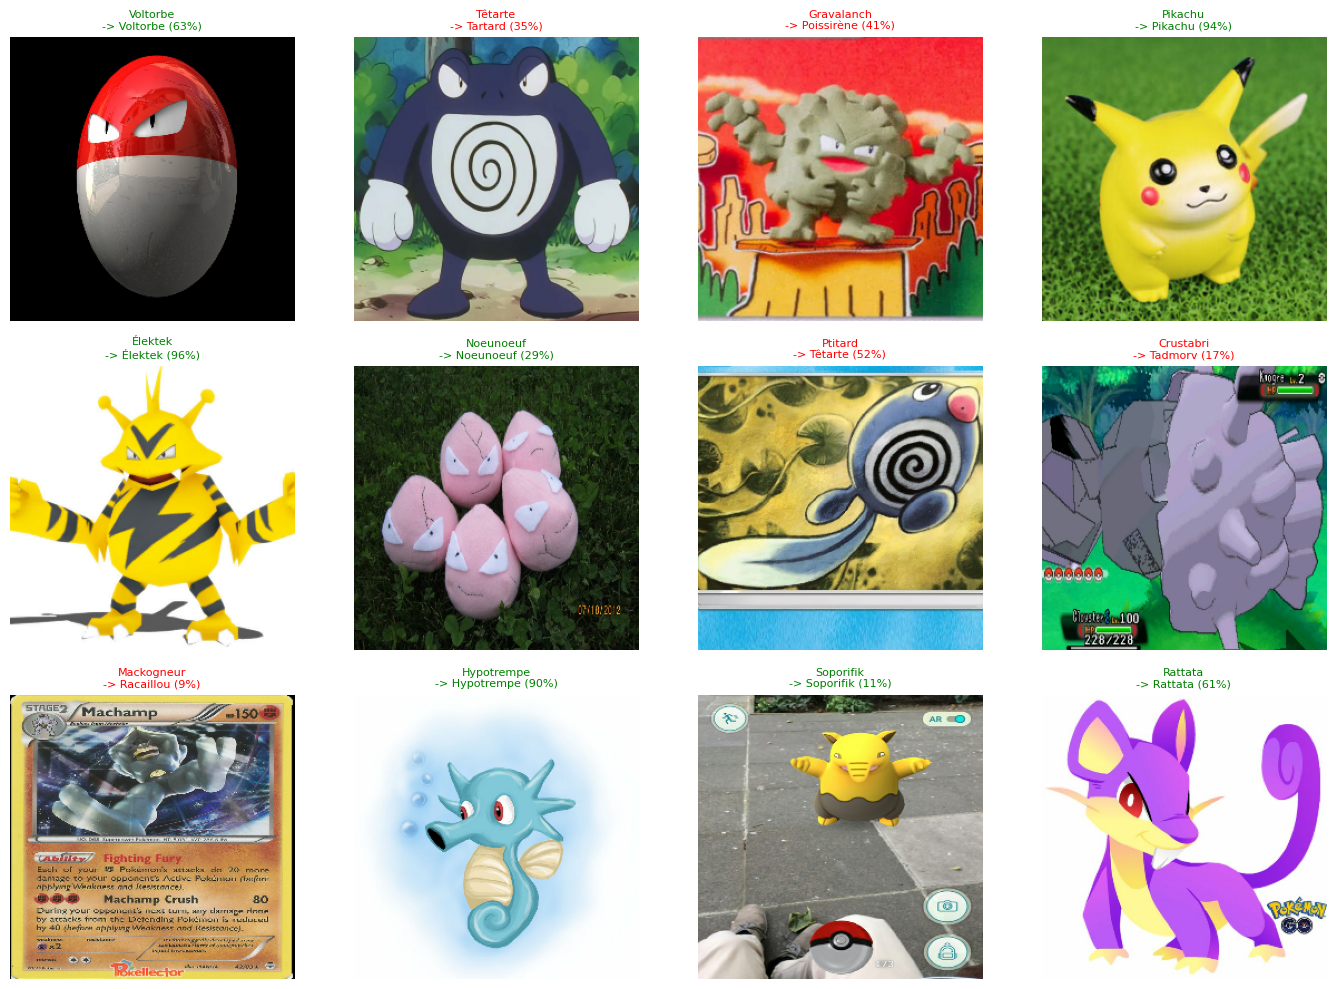

In [55]:
np.random.seed(42)
random_indices = np.random.choice(len(test_paths), 12, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(14, 10))

for idx, test_idx in enumerate(random_indices):
    img = tf.io.read_file(test_paths[test_idx])
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img_resized = tf.image.resize(img, (256, 256))
    
    prediction = model.predict(tf.expand_dims(img_resized / 255.0, 0), verbose=0)
    predicted_class = list(label_to_idx.keys())[np.argmax(prediction[0])]
    confidence = np.max(prediction[0])
    true_class = test_labels[test_idx]
    
    axes.flat[idx].imshow(img_resized.numpy().astype('uint8'))
    color = 'green' if predicted_class == true_class else 'red'
    axes.flat[idx].set_title(f"{true_class}\n-> {predicted_class} ({confidence*100:.0f}%)", 
                              fontsize=8, color=color)
    axes.flat[idx].axis('off')

plt.tight_layout()
plt.show()

## Test sur images externes

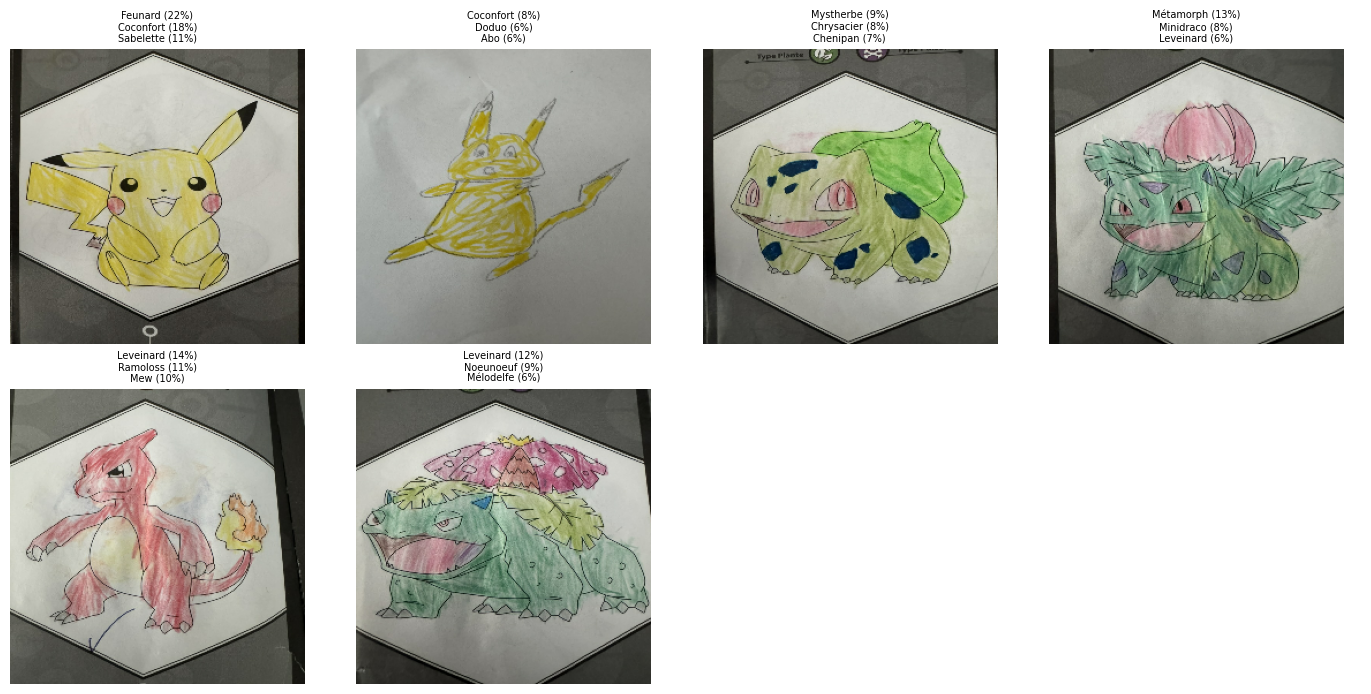

In [56]:
external_dir = Path('./Test_Img_Externes')

if external_dir.exists():
    external_images = [f for f in external_dir.iterdir() 
                       if f.suffix.lower() in image_extensions]
    
    if external_images:
        num_images = min(len(external_images), 8)
        fig, axes = plt.subplots(2, 4, figsize=(14, 7))
        
        for idx, img_path in enumerate(external_images[:num_images]):
            img = tf.io.read_file(str(img_path))
            img = tf.image.decode_image(img, channels=3, expand_animations=False)
            img_resized = tf.image.resize(img, (256, 256))
            
            prediction = model.predict(tf.expand_dims(img_resized / 255.0, 0), verbose=0)
            top3_idx = np.argsort(prediction[0])[-3:][::-1]
            
            axes.flat[idx].imshow(img_resized.numpy().astype('uint8'))
            title = "\n".join([f"{list(label_to_idx.keys())[i]} ({prediction[0][i]*100:.0f}%)" 
                               for i in top3_idx])
            axes.flat[idx].set_title(title, fontsize=7)
            axes.flat[idx].axis('off')
        
        for idx in range(num_images, 8):
            axes.flat[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
else:
    print(f"Répertoire {external_dir} non trouvé")